In [33]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [34]:
include("../../util.j")

colnorm (generic function with 1 method)

In [35]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [36]:
#using Pkg
#Pkg.add("ProgressMeter");

In [102]:
# Set the parameters for SLMC model #

N = 1200 # sample size
Nobs = 1000;
q = 10; p = 2; K = 2
Σ = Diagonal([0.5, 0.1, 0.4, 0.2, 0.3, 0.25, 0.35, 0.45, 0.15, 0.05]) ;
β = [1.0 -1.0 1.0 -0.5 2.0 -1.5 0.5 0.3 -2.0 1.5
     -5.0 2.0 3.0 -2.0 -6.0 4.0 5.0 -3.0 6.0 -4.0];
ϕ1 = 6.0; ϕ2 = 18.0; ν1 = 0.5; ν2 = 0.5;   # parameter for the independent F
Λ = [1.0 -1.0 1.0 -1.0 1.0 -0.5 2.0 -1.5 0.5 0.3 
     -5.0 2.0 3.0 -2.0 0.0 2.0 -3.0 -1.0 0.3 -0.5]; # loading matrix

# priors #
μβ = fill(0.0, p, q); Vβ =[[100.0 0.0]; [0.0 100.0]];
μΛ = fill(0.0, K, q); VΛ =[[100.0 0.0]; [0.0 100.0]];
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

In [117]:
# Generate simulation data #

Random.seed!(1234);
coords = rand(2, N);                                          # random location over unit square
X = hcat(fill(1, (N,)), rand(N));                             # design matrix
D = pairwise(Euclidean(), coords, dims = 2);                  # distance matrix
ρ1 = exp.(-ϕ1 * D); ρ2 = exp.(-ϕ2 * D);    # covariance matrix
ω = [rand(MvNormal(ρ1), 1) rand(MvNormal(ρ2), 1)] * Λ; # latent process
Y = X * β + ω + [rand(Normal(0, Σ[i, i]), 1)[1] for j in 1:N, i in 1:q];  

In [118]:
# Some data preparations #

ordx = sortperm(coords[1, :]);                                # sort order based on the first coordinates
X_ord = X[ordx, :]; Y_ord = Y[ordx, :]; ω_ord = ω[ordx, :];   # sorted data
ω_incp_obs = ω_ord + fill(1.0, (N, 1)) * transpose(β[1, :]); # latent process + intercept
coords_ord = coords[:, ordx];
S_ind = [sample(1:N, Nobs, replace = false, ordered = true) for i in 1:q] 
                                                              # index of observed response for all q responses
S = sort(union(S_ind[1], S_ind[2], S_ind[3], S_ind[4], S_ind[5], S_ind[6], 
        S_ind[7], S_ind[8], S_ind[9], S_ind[10]));
M_ind = [setdiff(S, S_ind[i]) for i in 1:q];                  # in S not in S1
obs_ind = vcat([S_ind[i] .+ (i - 1) * N for i in 1:q]...)    # index of the observed location for all response among N locations
perm_ind = sortperm(vcat([S_ind[i] for i in 1:q]...))
#for i in 1:q
#    perm_ind = vcat(perm_ind, S_ind[i])
#end
#perm_ind = sortperm(perm_ind);
index_S = zeros(N);                                           # build index indicating which response are observed
for i in 1:q
    vi = zeros(N);
    vi[S_ind[i]] .= 1;
    index_S = index_S + 2^(i - 1) * vi
end
M_Sind = [findall(x -> mod(floor(x / 2^(i - 1)), 2) == 1, index_S[S]) for i in 1:q]
               # index of M1 among S 

m = 10; n = length(S);                                        # number of nearest neighbor                       
NN = BuildNN(coords_ord[:, S], m, 1.0);                            # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:n);                            # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):n, inner = m), 1:n);  # the index of rows

Lβ = cholesky(Vβ); LΛ = cholesky(VΛ); 


In [122]:
S_ind

10-element Array{Array{Int64,1},1}:
 [1, 2, 5, 6, 7, 9, 10, 11, 12, 13  …  1188, 1190, 1191, 1192, 1194, 1195, 1196, 1197, 1198, 1200]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1188, 1189, 1190, 1193, 1195, 1196, 1197, 1198, 1199, 1200]   
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 11  …  1188, 1189, 1190, 1191, 1193, 1194, 1195, 1196, 1197, 1198]   
 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11  …  1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200]  
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1188, 1189, 1191, 1192, 1193, 1194, 1196, 1197, 1199, 1200]   
 [1, 2, 4, 5, 7, 8, 9, 10, 11, 12  …  1189, 1190, 1191, 1193, 1195, 1196, 1197, 1198, 1199, 1200] 
 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  1189, 1190, 1191, 1192, 1193, 1195, 1196, 1197, 1198, 1200]  
 [1, 2, 3, 4, 6, 7, 8, 9, 10, 11  …  1189, 1190, 1191, 1192, 1194, 1195, 1196, 1197, 1198, 1200]  
 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11  …  1188, 1189, 1190, 1192, 1193, 1195, 1197, 1198, 1199, 1200]  
 [1, 2, 3, 4, 5, 6, 8, 10, 11, 12  …  1191, 1192, 1193, 1194, 1195, 1196,

In [119]:
# preallocation #

#F = Array{Float64,2}(undef, n , 3);                           # preallocate the matrix F
μ_m1 = Array{Float64, 2}(undef, N - Nobs, q);
μ_m2 = Array{Float64, 2}(undef, N - Nobs, q);
nIndx = length(NN.nnIndx);
A1 = Array{Float64}(undef, nIndx); D1 = Array{Float64}(undef, n);
A2 = Array{Float64}(undef, nIndx); D2 = Array{Float64}(undef, n);
I_A1 = SparseMatrixCSC{Float64,Int64};
I_A2 = SparseMatrixCSC{Float64,Int64}; 
A1_new = Array{Float64}(undef, nIndx); D1_new = Array{Float64}(undef, n);
A2_new = Array{Float64}(undef, nIndx); D2_new = Array{Float64}(undef, n);
I_A1_new = SparseMatrixCSC{Float64,Int64};
I_A2_new = SparseMatrixCSC{Float64,Int64}; 
Ystar = vcat(Y_ord[S, :], Lβ.L \ μβ, LΛ.L \ μΛ);             # will be updated after imputing missing response
Xstar = vcat([X_ord[S, :] fill(0.0, n, K)], [inv(Lβ.L) fill(0.0, p, K)], 
    [fill(0.0, K, p) inv(LΛ.L)]);      
Ψstar = fill(0.0, q, q); νstar = νΣ + n;
μγstar = vcat(μβ, μΛ); Vγstar = fill(0.0, p + K, p + K);
Y_Xm = fill(0.0, n, q); invVγstar = fill(0.0, p + K, p + K);

MCMC sampling algorithm
Q1: priors for $\nu_i$ 
Q2: $\phi_i$ may not be consistant, since the order can change 

In [120]:
# Preallocation for MCMC samples and Initalization #
N_sam = 20000;
γ_sam = Array{Float64, 3}(undef, p + K, q, N_sam + 1);
Σ_sam = Array{Float64, 2}(undef, q, N_sam + 1);
F_sam = Array{Float64, 3}(undef, n, K, N_sam);
Y_m_sam = Array{Float64, 3}(undef, N - Nobs, q, N_sam);
A_sam = Array{Float64, 1}(undef, N_sam); # acceptance rate
lh_old = 1; lh_new = 1;     # record the likelihood for updating ranges

ϕ_sam = Array{Float64, 2}(undef, K, N_sam + 1);

γ_sam[:, :, 1] = fill(0.0, p + K, q);
Σ_sam[:, 1] = fill(0.2, q);
ϕ_sam[:, 1] = [6, 6];

precond_D = Array{Float64, 1}(undef, K * n);
RWM_scale = 0.5;                                              # random-walk metropolis step size scale 

In [124]:
S_ind[1]

1000-element Array{Int64,1}:
    1
    2
    5
    6
    7
    9
   10
   11
   12
   13
   14
   15
   16
    ⋮
 1186
 1187
 1188
 1190
 1191
 1192
 1194
 1195
 1196
 1197
 1198
 1200

In [ ]:
invD = Diagonal([[Σ_sam[j, 1] for j in 1:q if ] for i in 1:N if (index_S[i] > 0)])

In [78]:
# for loop for MCMC chain #
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    # Build the matrix D_Sigma_o^{1/2} #
    Dic_diag = Dict(2^0 => sparse(1I, 1, 1) * (1 / sqrt(Σ_sam[:, :, l][1, 1])), 
        2^1 => sparse(1I, 1, 1) * (1 / sqrt(Σ_sam[:, :, l][2, 2])), 
        (2^0 + 2^1)=> sparse(sqrt(inv(Σ_sam[:, :, l]))));
    invD = blockdiag([Dic_diag[i] for i in index_S if i > 0]...);
                    
    # Build the matrix for the first iteration #
    if l == 1
        getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[1, l], 0.5, A1, D1);
        getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[2, l], 0.5, A2, D2);
        I_A1 = sparse(nnIndx_row, nnIndx_col, vcat(-A1, ones(n)));
        I_A2 = sparse(nnIndx_row, nnIndx_col, vcat(-A2, ones(n)));
    end
                    

    # Build Ytilde Xtilde
    Ytilde = vcat(invD * vcat(Y_ord[S1_ind, 1] - X_ord[S1_ind, :] * γ_sam[1:p, 1, l], 
                            Y_ord[S2_ind, 2] - X_ord[S2_ind, :] * γ_sam[1:p, 2, l])[perm_ind], zeros(K * n));
    Xtilde = vcat(invD * kron(sparse(transpose(γ_sam[(p + 1):(p + K), :, l])), 
                            sparse(1:N, 1:N, ones(N)))[obs_ind, 
                            vcat(S, S .+ N)][perm_ind, :],
             blockdiag(Diagonal(1 ./ sqrt.(D1)) * I_A1, Diagonal(1 ./ sqrt.(D2)) * I_A2));
                
    # use LSMR to generate sample of F #       
    nsam = length(Ytilde);
    Precond_D = colnorm(Xtilde);
    F_sam[:, :, l] = reshape(Diagonal(1 ./ Precond_D) * lsmr(Xtilde * Diagonal(1 ./ Precond_D), 
                            Ytilde + rand(Normal(), nsam)), :, K);               
                    
    # impute missing response  over S#
    Xstar[1:n, (p + 1):(p + K)] = F_sam[:, :, l];        # update matrix Xstar with F
    mul!(μ_m1, Xstar[M1_Sind, :], γ_sam[:, :, l]);
    mul!(μ_m2, Xstar[M2_Sind, :], γ_sam[:, :, l]);

    Y_m1_sam[:, l] = μ_m1[:, 1] + (Σ_sam[1, 2, l] / Σ_sam[2, 2, l]) * 
            (Y_ord[M1_ind, 2] - μ_m1[:, 2]) + 
            rand(Normal(0, sqrt(Σ_sam[1, 1, l] - Σ_sam[1, 2, l]^2 / Σ_sam[2, 2, l])), length(M1_ind));
    Y_m2_sam[:, l] = μ_m2[:, 2] + (Σ_sam[2, 1, l] / Σ_sam[1, 1, l]) * 
            (Y_ord[M2_ind, 1] - μ_m2[:, 1]) + 
            rand(Normal(0, sqrt(Σ_sam[2, 2, l] - Σ_sam[2, 1, l]^2 / Σ_sam[1, 1, l])), length(M2_ind)); # improve?...
    
                    
    # use MNIW to sample γ Σ #
    Ystar[M1_Sind, 1] = Y_m1_sam[:, l];              # update Ystar with imputed response
    Ystar[M2_Sind, 2] = Y_m2_sam[:, l]; 
    invVγstar = cholesky(Xstar'Xstar);
    mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar.U \ (invVγstar.L \ μγstar);
    Y_Xm = BLAS.gemm('N', 'N', -1.0, Xstar, μγstar) + Ystar;
    mul!(Ψstar, transpose(Y_Xm), Y_Xm); BLAS.axpy!(1.0, ΨΣ, Ψstar);

    Σ_sam[:, :, l + 1] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    γ_sam[:, :, l + 1] = (invVγstar.U \ reshape(rand(Normal(), (p + K) * q), (p + K), q)) * 
                    cholesky(Σ_sam[:, :, l + 1]).U + μγstar;          # sample γ    
                    
                    
    # use metropolis-hasting to update range
    ϕ_sam[:, l + 1] = ϕ_sam[:, l] + RWM_scale * rand(Normal(), K); # propose next sample point
    if all(x -> (x < ϕU && x > ϕL), ϕ_sam[:, l + 1])
        lh_old = -0.5 * (sum(log.(D1)) + sum(log.(D2)) + 
                    norm((I_A1 * F_sam[:, 1, l]) ./ sqrt.(D1))^2 + 
                    norm((I_A2 * F_sam[:, 2, l]) ./ sqrt.(D2))^2);
        getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[1, l + 1], 0.5, A1_new, D1_new);
        getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[2, l + 1], 0.5, A2_new, D2_new);
        I_A1_new = sparse(nnIndx_row, nnIndx_col, vcat(-A1_new, ones(n)));
        I_A2_new = sparse(nnIndx_row, nnIndx_col, vcat(-A2_new, ones(n)));          
        lh_new = -0.5 * (sum(log.(D1_new)) + sum(log.(D2_new)) + 
                    norm((I_A1_new * F_sam[:, 1, l]) ./ sqrt.(D1_new))^2 + 
                    norm((I_A2_new * F_sam[:, 2, l]) ./ sqrt.(D2_new))^2);
        A_sam[l] = exp(lh_new - lh_old);
        if rand(1)[1] < A_sam[l]
            I_A1 = copy(I_A1_new); I_A2 = copy(I_A2_new);          # update and update the corresponding I_A D
            D1 = copy(D1_new); D2 = copy(D2_new); 
        else
            ϕ_sam[:, l + 1] = ϕ_sam[:, l]; # Don't update
        end         
    else
        A_sam[l] = 0.0;
        ϕ_sam[:, l + 1] = ϕ_sam[:, l];   # Don't update when falling out of the supports
    end                      
    
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 1:15:55


Posterior prediction

In [79]:
# prediction preparison
N_pre_burn = Integer(trunc(0.75 * N_sam));
M_ind = setdiff(1:N, S); NM = length(M_ind)
F_M_sam = Array{Float64, 3}(undef, NM, K, N_sam - N_pre_burn + 1);
Y_M_sam = Array{Float64, 3}(undef, NM, q, N_sam - N_pre_burn + 1);

# construct Atilde Dtilde #

using RCall
@rput coords_ord
@rput S
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(t(coords_ord[, S]), t(coords_ord[, -S]), k = m)
"""
@rget nn_mod_ho
Atilde = Array{Float64}(undef, NM * m); Dtilde = Array{Float64}(undef, NM);
MnnIndxLU = collect(1:m:(NM * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');

In [80]:
for i in N_pre_burn:N_sam
    for j in 1:K
        # update F
        getAD(coords_ord[:, S], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, 
             ϕ_sam[j, i + 1], 0.5, Atilde, Dtilde)
        AtildeM = sparse(repeat(1:NM, inner = m), MnnIndx, Atilde, NM, n);
        F_M_sam[:, j, (i - N_pre_burn + 1)] = AtildeM * F_sam[:, j, i] + sqrt.(Dtilde) .* rand(Normal(), NM)
    end 
    # update Y
    Y_M_sam[:, :, (i - N_pre_burn + 1)] = X_ord[M_ind, :] * γ_sam[1:p, :, i + 1] + 
        F_M_sam[:, :, (i - N_pre_burn + 1)] *  γ_sam[(p + 1):(p + K), :, i + 1] + 
        transpose(rand(MvNormal(Σ_sam[:, :, i + 1]), NM))
end

# MCMC Chain check

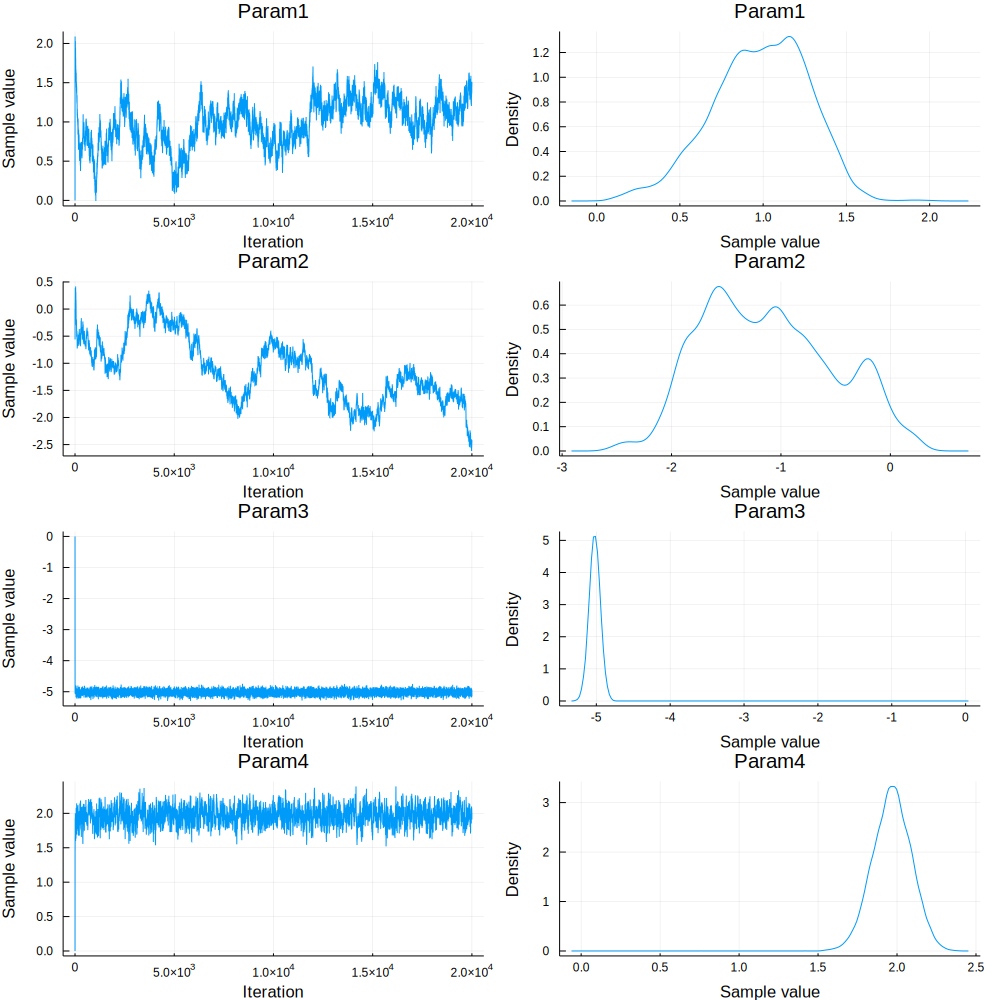

In [27]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, p * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[1, 1, :], γ_sam[1, 2, :], γ_sam[2, 1, :], γ_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

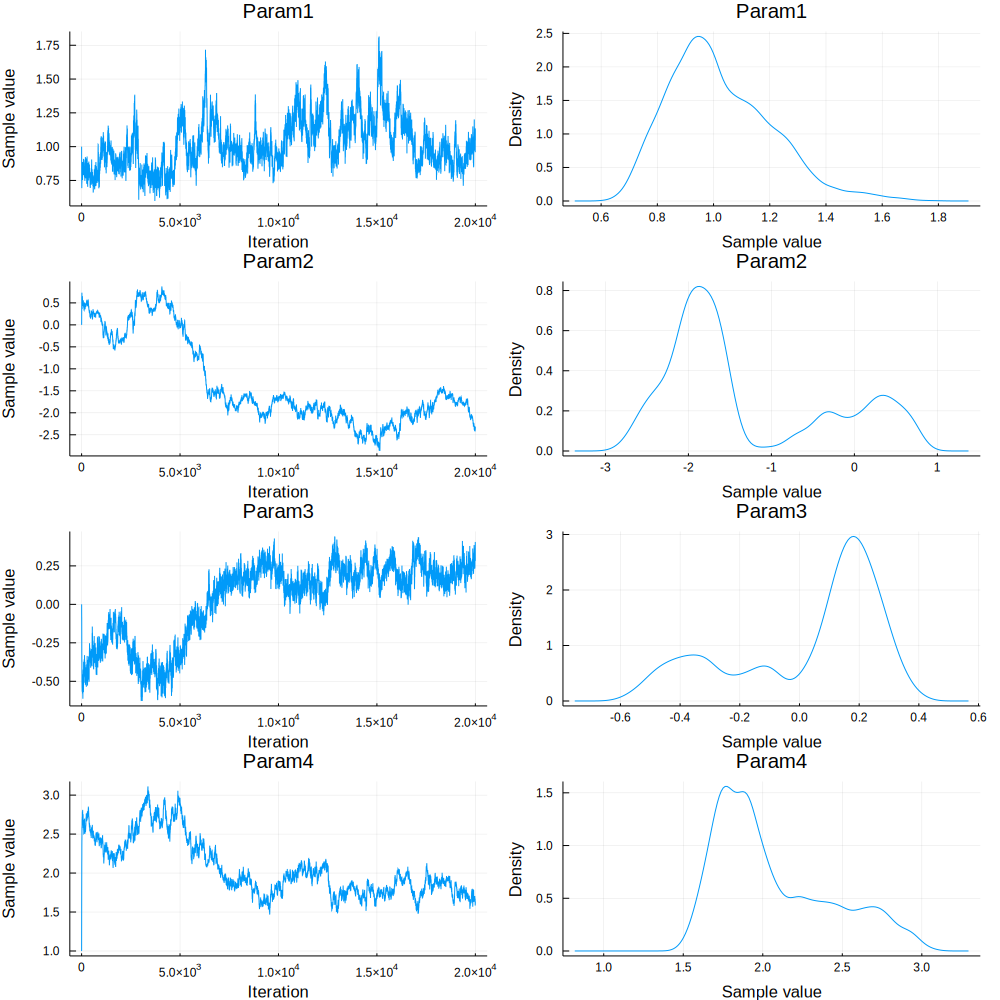

In [28]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K * q, 1);
Λ_pos_sam[:, :, 1] = hcat(γ_sam[3, 1, :], γ_sam[3, 2, :], γ_sam[4, 1, :], γ_sam[4, 2, :]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

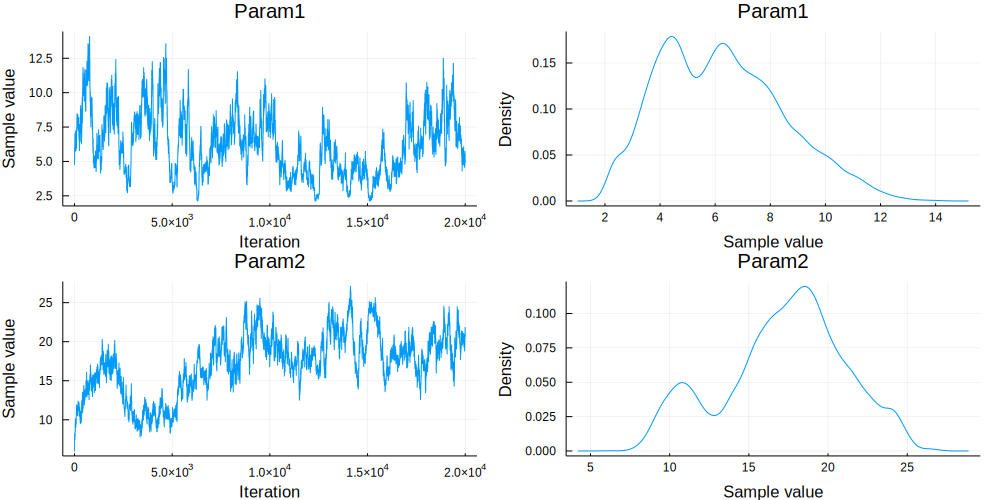

In [29]:
ϕ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K, 1);
ϕ_pos_sam[:, :, 1] = hcat(ϕ_sam[1, :], ϕ_sam[2, :]);
ϕ_chain = Chains(ϕ_pos_sam);
pϕ = plot(ϕ_chain)

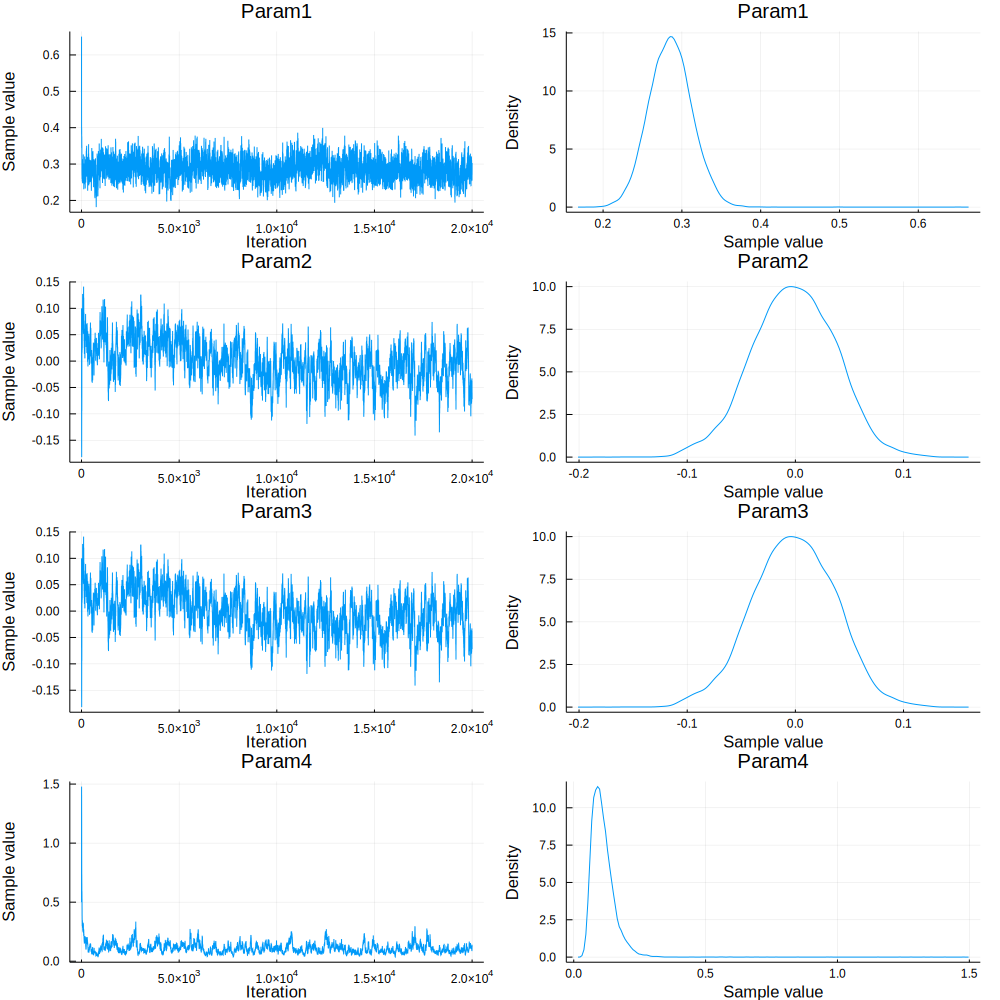

In [30]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, :], Σ_sam[1, 2, :], Σ_sam[2, 1, :], Σ_sam[2, 2, :]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

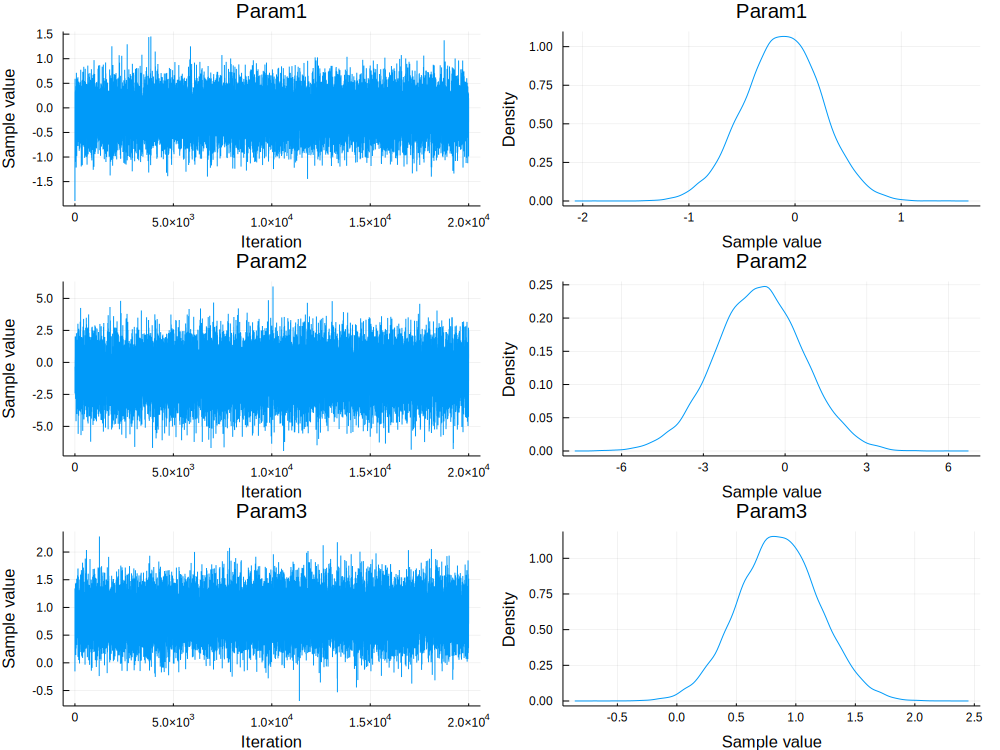

In [31]:
ω_incp_obs_pos_sam = Array{Float64, 3}(undef, n, q, N_sam);
lll = fill(1.0, (n, 1));
for i in 1:N_sam
    ω_incp_obs_pos_sam[:, :, i] = F_sam[:, :, i] * γ_sam[(p + 1):(p + K), :, i + 1] + 
                     lll * transpose(γ_sam[1, :, i + 1]);
end
truncindex = 1;#Integer(trunc(N_sam / 2));
ω_incp_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex  + 1, 3, 1);
ω_incp_pos_sam[:, :, 1] = hcat(ω_incp_obs_pos_sam[1, 1, truncindex:N_sam], 
    ω_incp_obs_pos_sam[1, 2, truncindex:N_sam], ω_incp_obs_pos_sam[200, 1, truncindex:N_sam]);
ω_incp_chain = Chains(ω_incp_pos_sam);
pΣ = plot(ω_incp_chain)

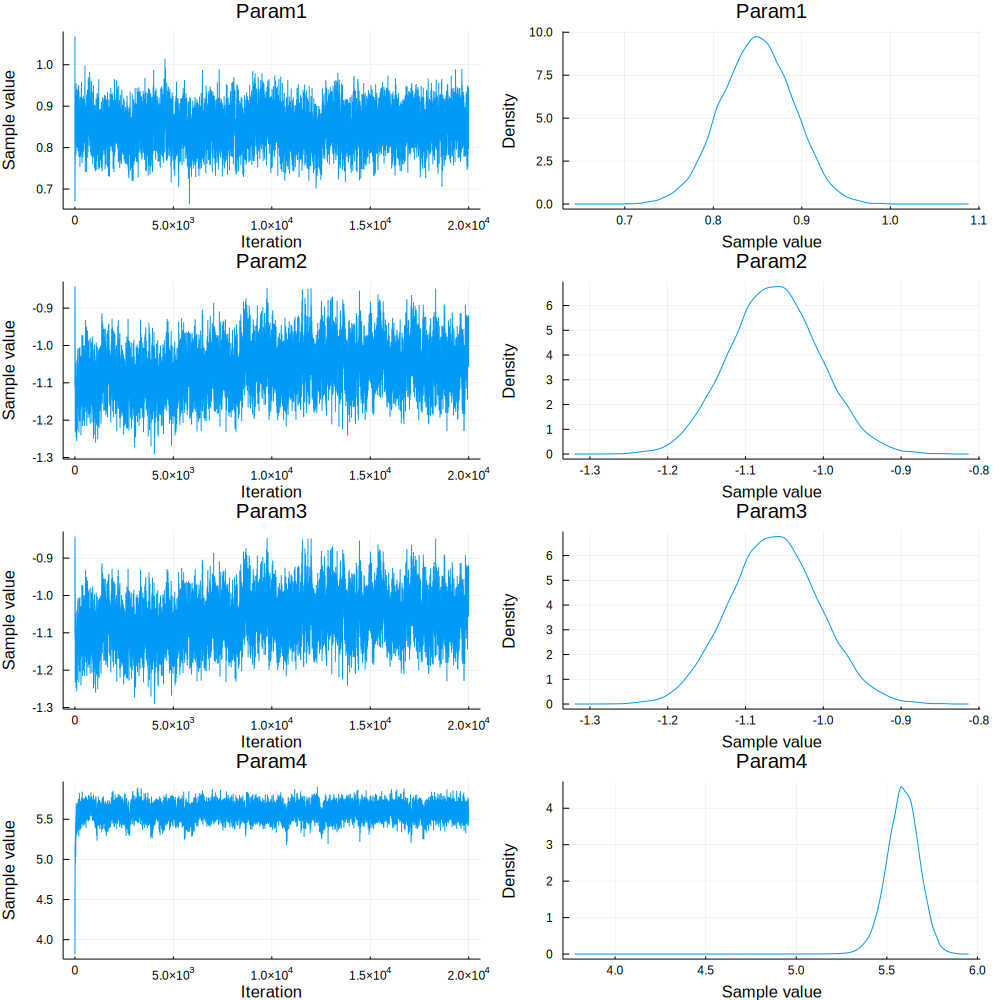

In [32]:
# check the variance covariance across latent process
cov_pos = Array{Float64, 3}(undef, q, q, N_sam);
for i in 1:N_sam
    cov_pos[:, :, i] = cov(F_sam[:, :, i] * γ_sam[(p + 1):(p + K), :, i + 1])
end   
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
    cov_pos[2, 1, :], cov_pos[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

In [33]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
  0.834605  -1.10556
 -1.10556    5.42519

# Posterior Inference 

In [68]:
N_Inf_burn = Integer(trunc(0.75 * N_sam));
ω_incp_obs_pos_qt = Array{Float64, 3}(undef, n, q, 3);
for j in 1:q
    for i in 1:n
        ω_incp_obs_pos_qt[i, j, :] = quantile(ω_incp_obs_pos_sam[i, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975])
    end
end
# count the covarage of 95% CI #
count_ω_incp = fill(0.0, 2);
for j in 1:q
    for i in 1:n
        count_ω_incp[j] = count_ω_incp[j] + 
        ((ω_incp_obs_pos_qt[i, j, 1] < ω_incp_obs[S[i], j]) && 
            (ω_incp_obs_pos_qt[i, j, 3] > ω_incp_obs[S[i], j]))
    end
end
count_ω_incp

2-element Array{Float64,1}:
 1123.0
 1038.0

In [69]:
count_ω_incp ./ n

2-element Array{Float64,1}:
 0.9590093936806149
 0.8864218616567037

In [70]:
summary_table = Array{Float64, 2}(undef, (p - 1) * q + (q * q - 1) * 2 + q, 5);
summary_table[1, :] = vcat(β[2, 1], mean(γ_sam[2, 1, N_Inf_burn:(N_sam + 1)]),
    quantile(γ_sam[2, 1, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[2, 2], mean(γ_sam[2, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(γ_sam[2, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(Σ[1, 1], mean(Σ_sam[1, 1, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[1, 1, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(Σ[1, 2], mean(Σ_sam[1, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[1, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(Σ[2, 2], mean(Σ_sam[2, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[2, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(covω[1, 1], mean(cov_pos_sam[N_Inf_burn:N_sam, 1, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 1, 1], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(covω[1, 2], mean(cov_pos_sam[N_Inf_burn:N_sam, 2, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 2, 1], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(covω[2, 2], mean(cov_pos_sam[N_Inf_burn:N_sam, 4, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 4, 1], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(ϕ1, mean(ϕ_sam[1, N_Inf_burn:N_sam]),
    quantile(ϕ_sam[1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(ϕ2, mean(ϕ_sam[2, N_Inf_burn:N_sam]),
    quantile(ϕ_sam[2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]", 
    "cov(ω)[1, 1]", "cov(ω)[1, 2]", "cov(ω)[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|              |   true |   mean | median |   2.5% |  97.5% |
|--------------|--------|--------|--------|--------|--------|
|      β[2, 1] |   -5.0 | -5.019 | -5.018 | -5.169 | -4.873 |
|      β[2, 2] |    2.0 |  1.972 |  1.975 |  1.725 |  2.202 |
|      Σ[1, 1] |    0.3 |   0.28 |   0.28 |  0.231 |  0.332 |
|      Σ[1, 2] |    0.0 | -0.018 | -0.016 | -0.089 |  0.044 |
|      Σ[2, 2] |    0.2 |  0.102 |  0.096 |  0.056 |  0.192 |
| cov(ω)[1, 1] |  0.835 |  0.855 |  0.856 |  0.779 |  0.931 |
| cov(ω)[1, 2] | -1.106 | -1.046 | -1.047 | -1.154 | -0.938 |
| cov(ω)[2, 2] |  5.425 |  5.593 |  5.594 |  5.424 |  5.751 |
|           ϕ1 |    6.0 |   6.19 |  6.147 |  2.371 | 10.365 |
|           ϕ2 |   18.0 | 19.309 | 19.121 | 14.588 | 24.319 |


In [55]:
# posterior prediction check #
N_Inf_burn = 1;
Y_M_pos_qt = Array{Float64, 3}(undef, NM, q, 3);
Y_M_pos_mean = Array{Float64, 2}(undef, NM, q);
for j in 1:q
    for i in 1:NM
        Y_M_pos_qt[i, j, :] = quantile(Y_M_sam[i, j, :], [0.025, 0.5, 0.975]);
        Y_M_pos_mean[i, j] = mean(Y_M_sam[i, j, :])
    end
end
# count the covarage of 95% CI #
count_Y_M = fill(0.0, 2);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        ((Y_M_pos_qt[i, j, 1] < Y_ord[M_ind[i], j]) && 
            (Y_M_pos_qt[i, j, 3] > Y_ord[M_ind[i], j]))
    end
end
count_Y_M

2-element Array{Float64,1}:
 27.0
 29.0

In [56]:
count_Y_M ./ NM

2-element Array{Float64,1}:
 0.9310344827586207
 1.0               

In [58]:
N_Inf_burn = Integer(trunc(0.75 * N_sam));
Y_m1_pos_qt = Array{Float64, 2}(undef, length(M1_ind), 3);
Y_m1_pos_mean = Array{Float64}(undef, length(M1_ind));
Y_m2_pos_qt = Array{Float64, 2}(undef, length(M2_ind), 3);
Y_m2_pos_mean = Array{Float64}(undef, length(M2_ind));
for i in 1:length(M1_ind)
    Y_m1_pos_qt[i, :] = quantile(Y_m1_sam[i, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
    Y_m1_pos_mean[i] = mean(Y_m1_sam[i, N_Inf_burn:N_sam])
end
for i in 1:length(M2_ind)
    Y_m2_pos_qt[i, :] = quantile(Y_m2_sam[i, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
    Y_m2_pos_mean[i] = mean(Y_m2_sam[i, N_Inf_burn:N_sam])
end
for i in 1:length(M1_ind)
    count_Y_M[1] = count_Y_M[1] + 
        ((Y_m1_pos_qt[i, 1] < Y_ord[M1_ind[i], 1]) && 
         (Y_m1_pos_qt[i, 3] > Y_ord[M1_ind[i], 1]))
end
for i in 1:length(M2_ind)
    count_Y_M[2] = count_Y_M[2] + 
        ((Y_m2_pos_qt[i, 1] < Y_ord[M2_ind[i], 2]) && 
         (Y_m2_pos_qt[i, 3] > Y_ord[M2_ind[i], 2]))
end
count_Y_M

2-element Array{Float64,1}:
 192.0
 187.0

In [59]:
count_Y_M ./ 200

2-element Array{Float64,1}:
 0.96 
 0.935

In [61]:
# calculate root mean square predictive error #
MSPE = (sum((Y_ord[M_ind, :] - Y_M_pos_mean).^2) + sum((Y_m1_pos_mean - Y_ord[M1_ind, 1]).^2 )
           + sum((Y_m2_pos_mean - Y_ord[M2_ind, 2]).^2)) / (2 * 200)
RMSPE = sqrt(MSPE); RMSPE

1.068867516505757

In [40]:
@save "../results/ω_incp_obs_pos_qt_BSLMC.jld"  ω_incp_obs_pos_qt